In [1]:
from probatus.feature_elimination import ShapRFECV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import settings

In [2]:
comorbidity_data_path = f'{settings.output_folder}icd_10_scaled.csv'
dietary_data_path = f'{settings.output_folder}diet.csv'
development_data_path = f'{settings.raw_data_folder}control/country_development_data.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'

In [3]:
food_data = pd.read_csv(dietary_data_path)
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Country
0,0.000030,0.326636,0.223147,0.0,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,...,0.090683,0.008648,0.101278,0.0,0.093136,0.113588,0.663569,0.246708,0.320304,Afghanistan
1,0.095202,0.741183,0.154200,0.0,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,...,0.000402,0.036580,0.119830,0.0,0.145522,0.221400,0.226743,0.149209,0.592018,Albania
2,0.011670,0.274016,0.034457,0.0,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,...,0.080131,0.086139,0.109900,0.0,0.176586,0.160859,0.745976,0.556105,0.585138,Algeria
3,0.251279,0.199301,0.053595,0.0,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,...,0.001731,0.534029,0.030582,0.0,0.130798,0.004750,0.764589,0.390946,0.078466,Angola
4,0.226478,0.656624,0.171604,0.0,0.131001,0.118321,0.346861,0.356505,0.621373,0.217600,...,0.216778,0.023982,0.225526,0.0,0.318216,0.043980,0.311472,0.346539,0.249017,Antigua and Barbuda


In [4]:
comorbidity_data = pd.read_csv(comorbidity_data_path)
comorbidity_data = comorbidity_data[comorbidity_data.columns[1:]]
comorbidity_data.head()

,"Endocrine, nutritional and metabolic diseases",Mental and behavioural disorders,Diseases of the nervous system,Diseases of the eye and adnexa and ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,Diseases of the digestive system,Diseases of the skin and subcutaneous tissue,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",External causes of morbidity and mortality,infectious and parasitic diseases,Neoplasms,Country
0,0.116819,0.003982,0.029111,0.358620,0.317068,0.106863,0.528042,0.099971,0.018798,0.302565,0.212921,0.186310,0.715048,0.498261,0.213145,0.204136,0.056119,Egypt
1,0.007047,0.000175,0.001227,0.004683,0.004962,0.002462,0.002225,0.003033,0.001920,0.007139,0.007311,0.069729,0.046214,0.032297,0.014364,0.005927,0.001819,Libyan Arab Jamahiriya
2,0.020303,0.000613,0.000982,0.000000,0.004010,0.002546,0.004058,0.012974,0.003137,0.002798,0.010916,0.006106,0.009091,0.001477,0.005225,0.003640,0.002076,Mauritius
3,0.000538,0.000065,0.000230,0.014048,0.000221,0.000137,0.000285,0.000948,0.000378,0.000178,0.003025,0.002662,0.004489,0.001181,0.000163,0.000224,0.000217,Mayotte
4,0.025356,0.001458,0.006734,0.037462,0.012426,0.006090,0.013126,0.015431,0.008845,0.019342,0.056512,0.181005,0.071820,0.124645,0.024429,0.018527,0.008840,Morocco


In [5]:
development_data = pd.read_csv(development_data_path)
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,...,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,...,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,...,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,...,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,...,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,...,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [6]:
reg = pd.read_csv(targets_path)
targets = reg[['Country', 'Deaths', 'Confirmed', 'Recovered']]
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Country      0
Deaths       0
Confirmed    0
Recovered    0
dtype: int64


,Country,Deaths,Confirmed,Recovered
0,Afghanistan,0.006186,0.142134,0.123374
1,Albania,0.050951,2.967301,1.792636
2,Algeria,0.006558,0.244897,0.167572
3,Angola,0.001461,0.061687,0.056808
4,Argentina,0.108227,4.356147,3.905192


In [7]:
merged = food_data.merge(comorbidity_data, how='inner', on='Country')
merged = merged.merge(development_data, on='Country', how='inner')
merged = merged.merge(targets, on='Country', how='inner')
merged.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature,Deaths,Confirmed,Recovered
0,0.185313,0.713814,0.173578,0.000000,0.161196,0.548327,0.037607,0.152709,0.821974,0.000000,...,0.030064,0.240648,0.022857,0.839132,0.496665,0.362201,0.791878,0.108227,4.356147,3.905192
1,0.023402,0.595196,0.259907,0.000000,0.198544,0.438625,0.031320,0.206262,0.338390,0.079870,...,0.001995,0.714081,0.000000,0.478700,0.540716,0.584616,0.529009,0.105345,5.681225,5.398410
2,0.248082,0.686090,0.260696,0.000655,0.057812,0.255123,0.115781,0.133698,0.643951,0.145771,...,0.016748,0.955444,0.025714,0.960246,0.648240,0.525721,0.934468,0.003530,0.112025,0.101289
3,0.334282,0.700335,0.721411,0.000218,0.079941,0.451243,0.074344,0.132597,0.431510,0.000045,...,0.006017,0.714796,0.028571,0.482139,0.508405,0.497334,0.511132,0.089679,4.739982,4.496870
4,0.149855,0.529113,0.191850,0.000000,0.155133,0.402945,0.301188,0.176358,0.568194,0.790046,...,0.000162,0.245413,0.037143,0.933904,0.841944,0.786833,0.960158,0.006272,0.583972,0.470035


In [8]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_all =  merged.columns.drop(['Country'])
features_all = features_all.drop(label_values)
features_all = features_all.drop(['WHO code', 'FAO code'])

In [9]:
X_all = merged[features_all]
Y_all = merged[label_values]

In [10]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [11]:
def rfecv_shap_algorithm(estimator, X, Y, algorithm, step=1, score='neg_median_absolute_error'):
  shap_elimination = ShapRFECV(clf=estimator, step=step, cv=7, scoring=score, n_jobs=-1)
  shap_report = shap_elimination.fit_compute(X, Y)
  best_features_rfe_shap = shap_report[shap_report['val_metric_mean'] == shap_report['val_metric_mean'].max()]
  features_shap = list(best_features_rfe_shap['features_set'].values[0])
  features_shap_cv = {}
  features_shap_cv['algorithm'] = 'rfe - measure shap ' + algorithm
  features_shap_cv['selected_features'] = features_shap
  features_shap_cv['number_of_features'] = len(features_shap)
  features_shap_cv['neg_mae_score_cv'] = shap_report['val_metric_mean'].max()
  feat_shap = pd.DataFrame(features_shap_cv)
  feat_shap.to_csv(f'{settings.features_folder}selected_features_rfe_shap_' + algorithm + '.csv', index=False)
  return feat_shap

In [12]:
PARAMS = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 4, 5, 6],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200]
}

In [13]:
xgb_all_params, xgb_all_score = hyper_parameter_search(X_all, Y_all['Deaths'], PARAMS)

In [14]:
print(f'best parameters: {xgb_all_params}')
print(f'score: {xgb_all_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 6, 'n_estimators': 50}
score: -0.03317190973020206


In [15]:
xgb_all = XGBRegressor(gamma = xgb_all_params['gamma'],
                               learning_rate = xgb_all_params['learning_rate'], 
                               max_depth = xgb_all_params['max_depth'],
                               min_child_weight = xgb_all_params['min_child_weight'], 
                               n_estimators = xgb_all_params['n_estimators'],
                               random_state=0)

In [16]:
rfecv_xgb_all = rfecv_shap_algorithm(xgb_all, X_all, Y_all['Deaths'], 'all')

In [17]:
rfecv_xgb_all

,algorithm,selected_features,number_of_features,neg_mae_score_cv
0,rfe - measure shap all,Animal fats,8,-0.023
1,rfe - measure shap all,Meat,8,-0.023
2,rfe - measure shap all,Diseases of the skin and subcutaneous tissue,8,-0.023
3,rfe - measure shap all,Fruits - Excluding Wine,8,-0.023
4,rfe - measure shap all,Summer Average Temperature,8,-0.023
5,rfe - measure shap all,Mental and behavioural disorders,8,-0.023
6,rfe - measure shap all,Min Longitude,8,-0.023
7,rfe - measure shap all,Alcoholic Beverages,8,-0.023


In [18]:
selected_features_all = rfecv_xgb_all['selected_features'].values

In [49]:
X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(
    X_all[selected_features_all],
    Y_all,
    test_size = 0.2,
    random_state=0
)

In [50]:
xgb_all.fit(X_train_all, Y_train_all['Deaths'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=2,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
unscaled_food = pd.read_csv(f'{settings.output_folder}diet_unscaled.csv')
unscaled_comorbidity = pd.read_csv(f'{settings.output_folder}icd_10.csv')
unscaled_comorbidity = unscaled_comorbidity[unscaled_comorbidity.columns[1:]]
unscaled_development = pd.read_csv(f'{settings.raw_data_folder}control/control_data_unscaled.csv')
unscaled_development.dropna(inplace=True)
unscaled_development['Undernourished'] = [float(val) if val != '<2.5' else 2.5 for val in unscaled_development.Undernourished]
unscaled_food = unscaled_food[unscaled_food.columns[1:]]
unscaled_food.drop(['Population', 'Active', 'Obesity'], axis=1, inplace=True)
unscaled_data = unscaled_food.merge(unscaled_comorbidity, on='Country', how='inner')
unscaled_data = unscaled_data.merge(unscaled_development, on='Country', how='inner')

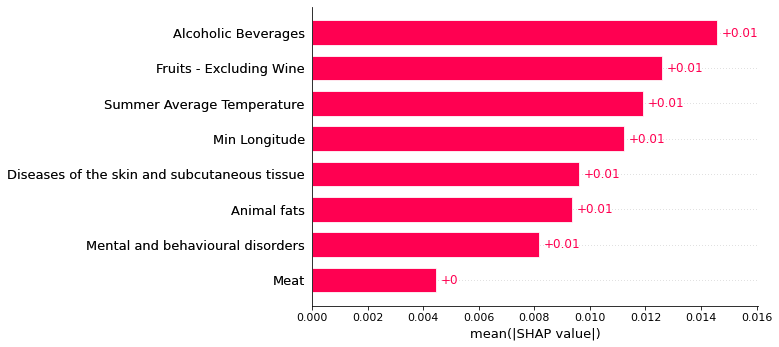

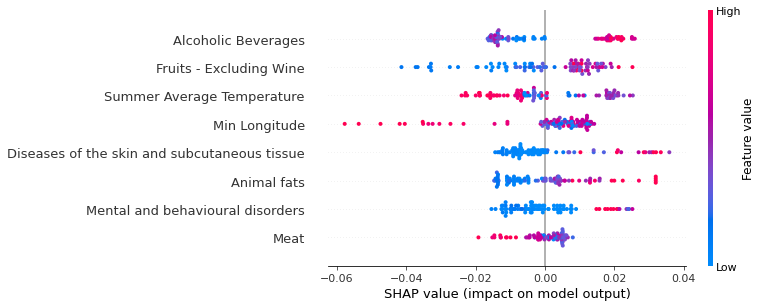

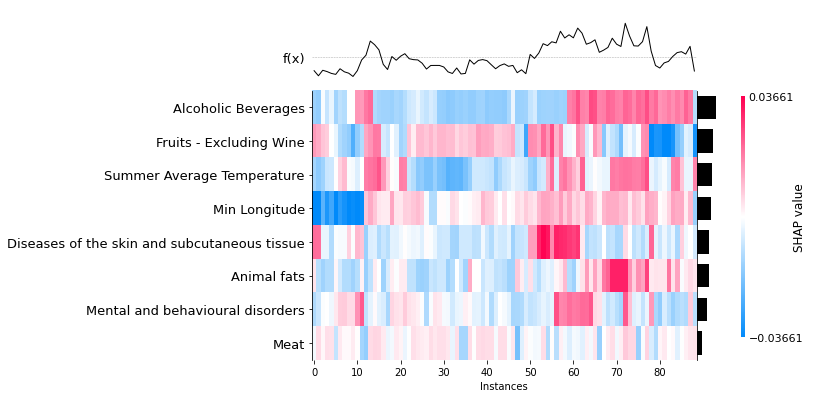

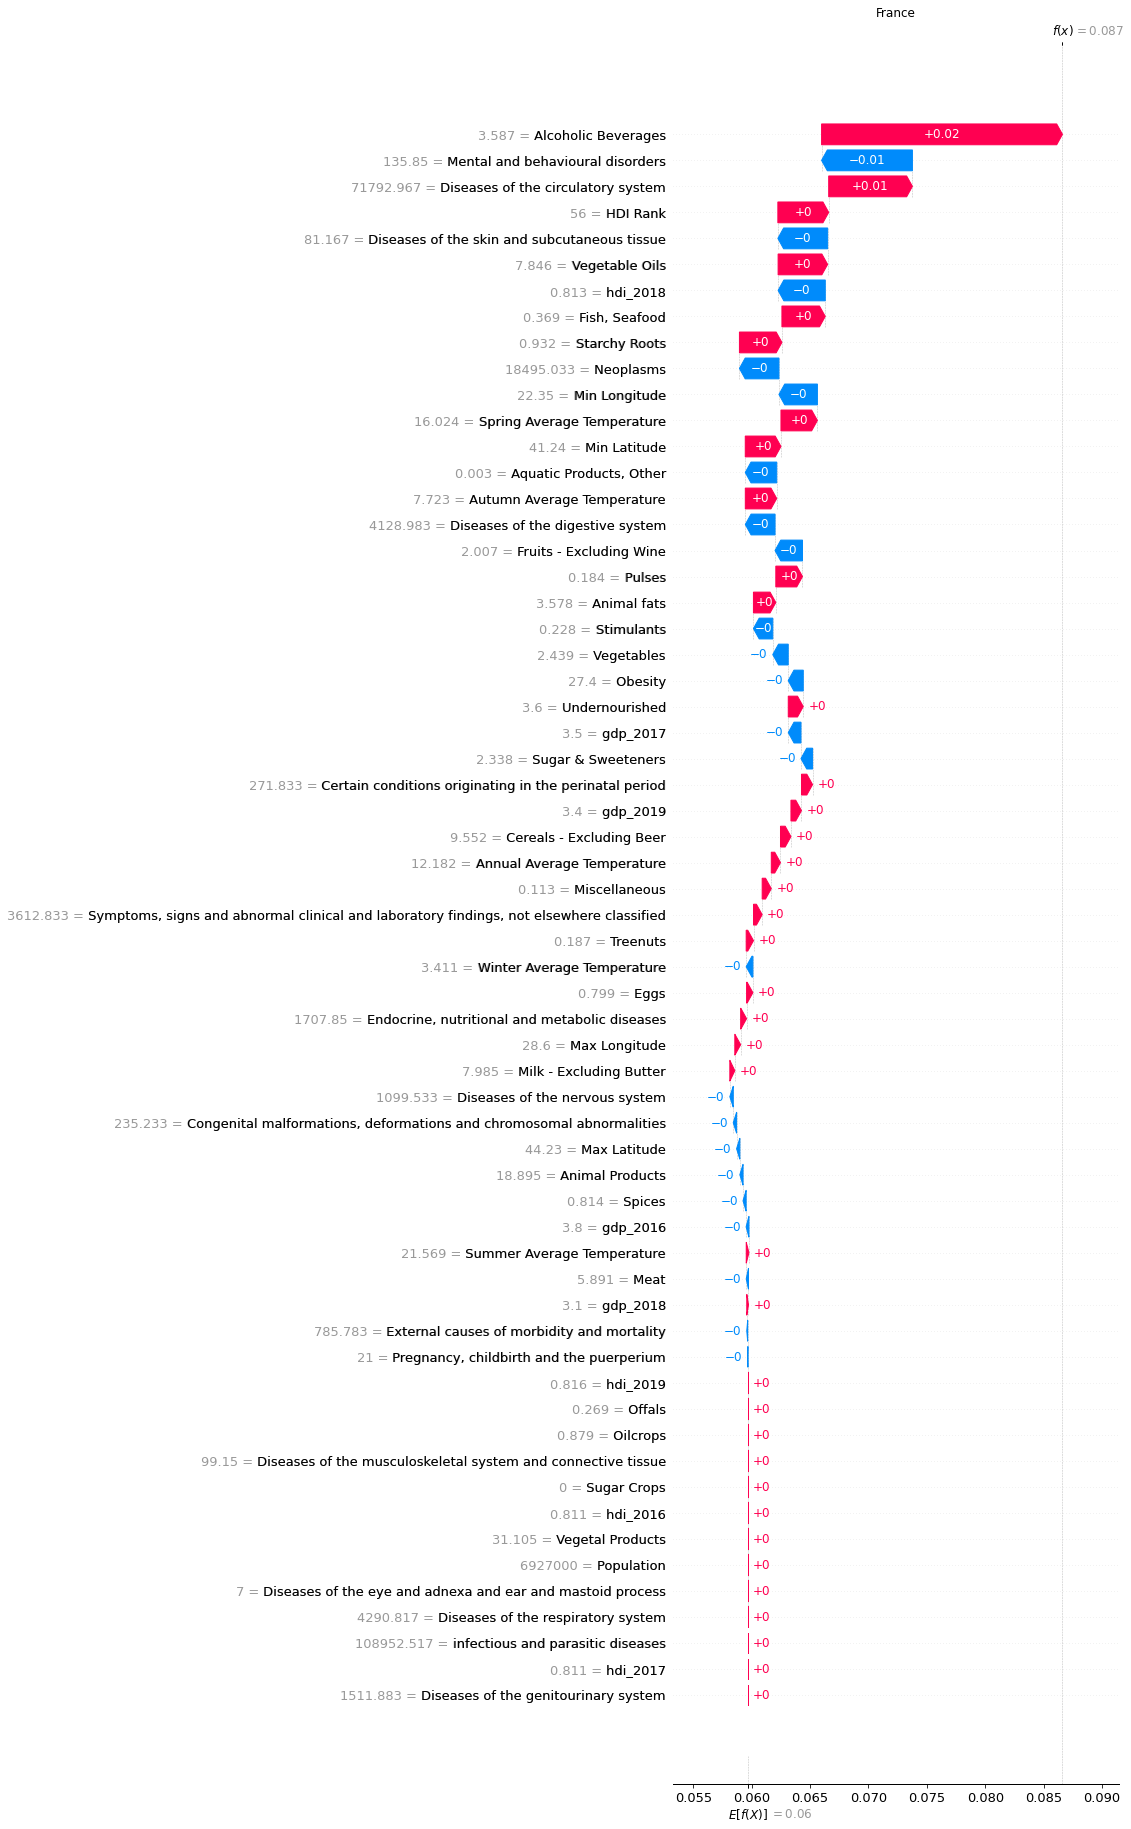

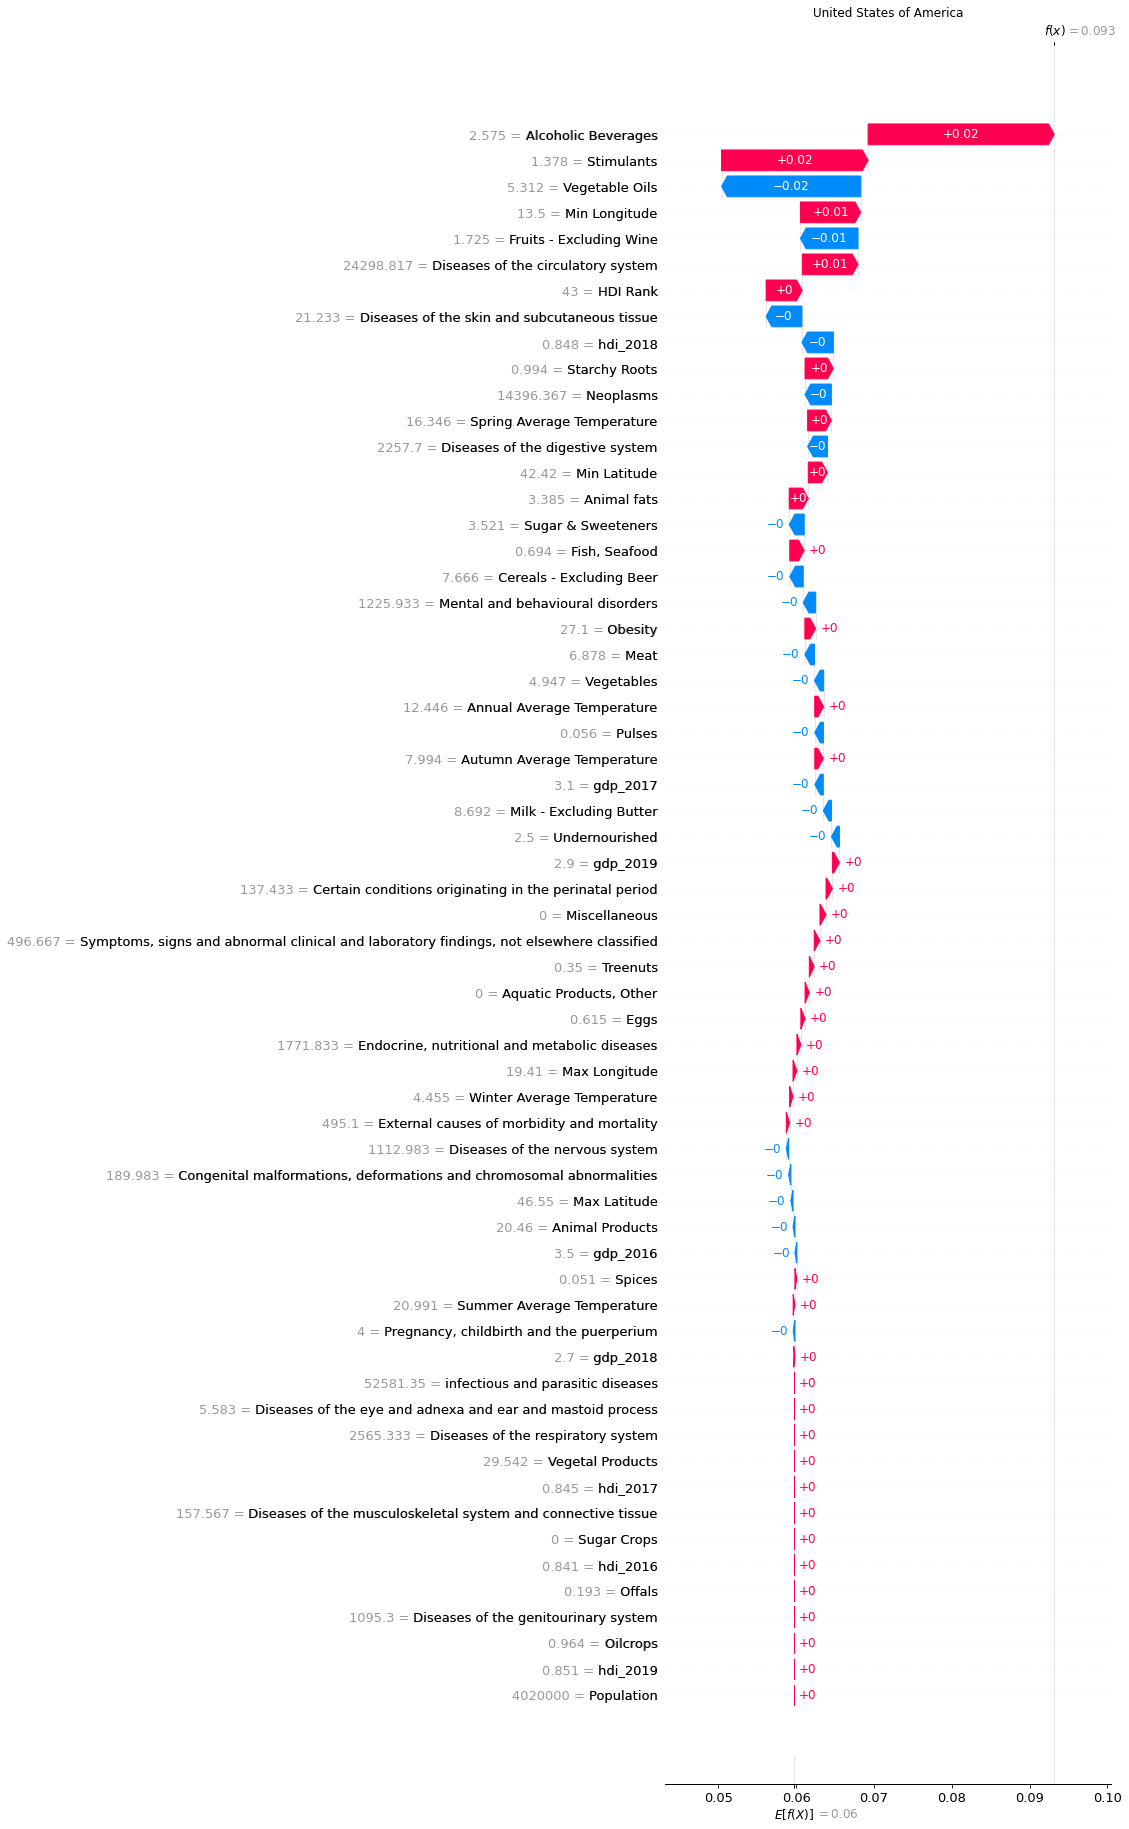

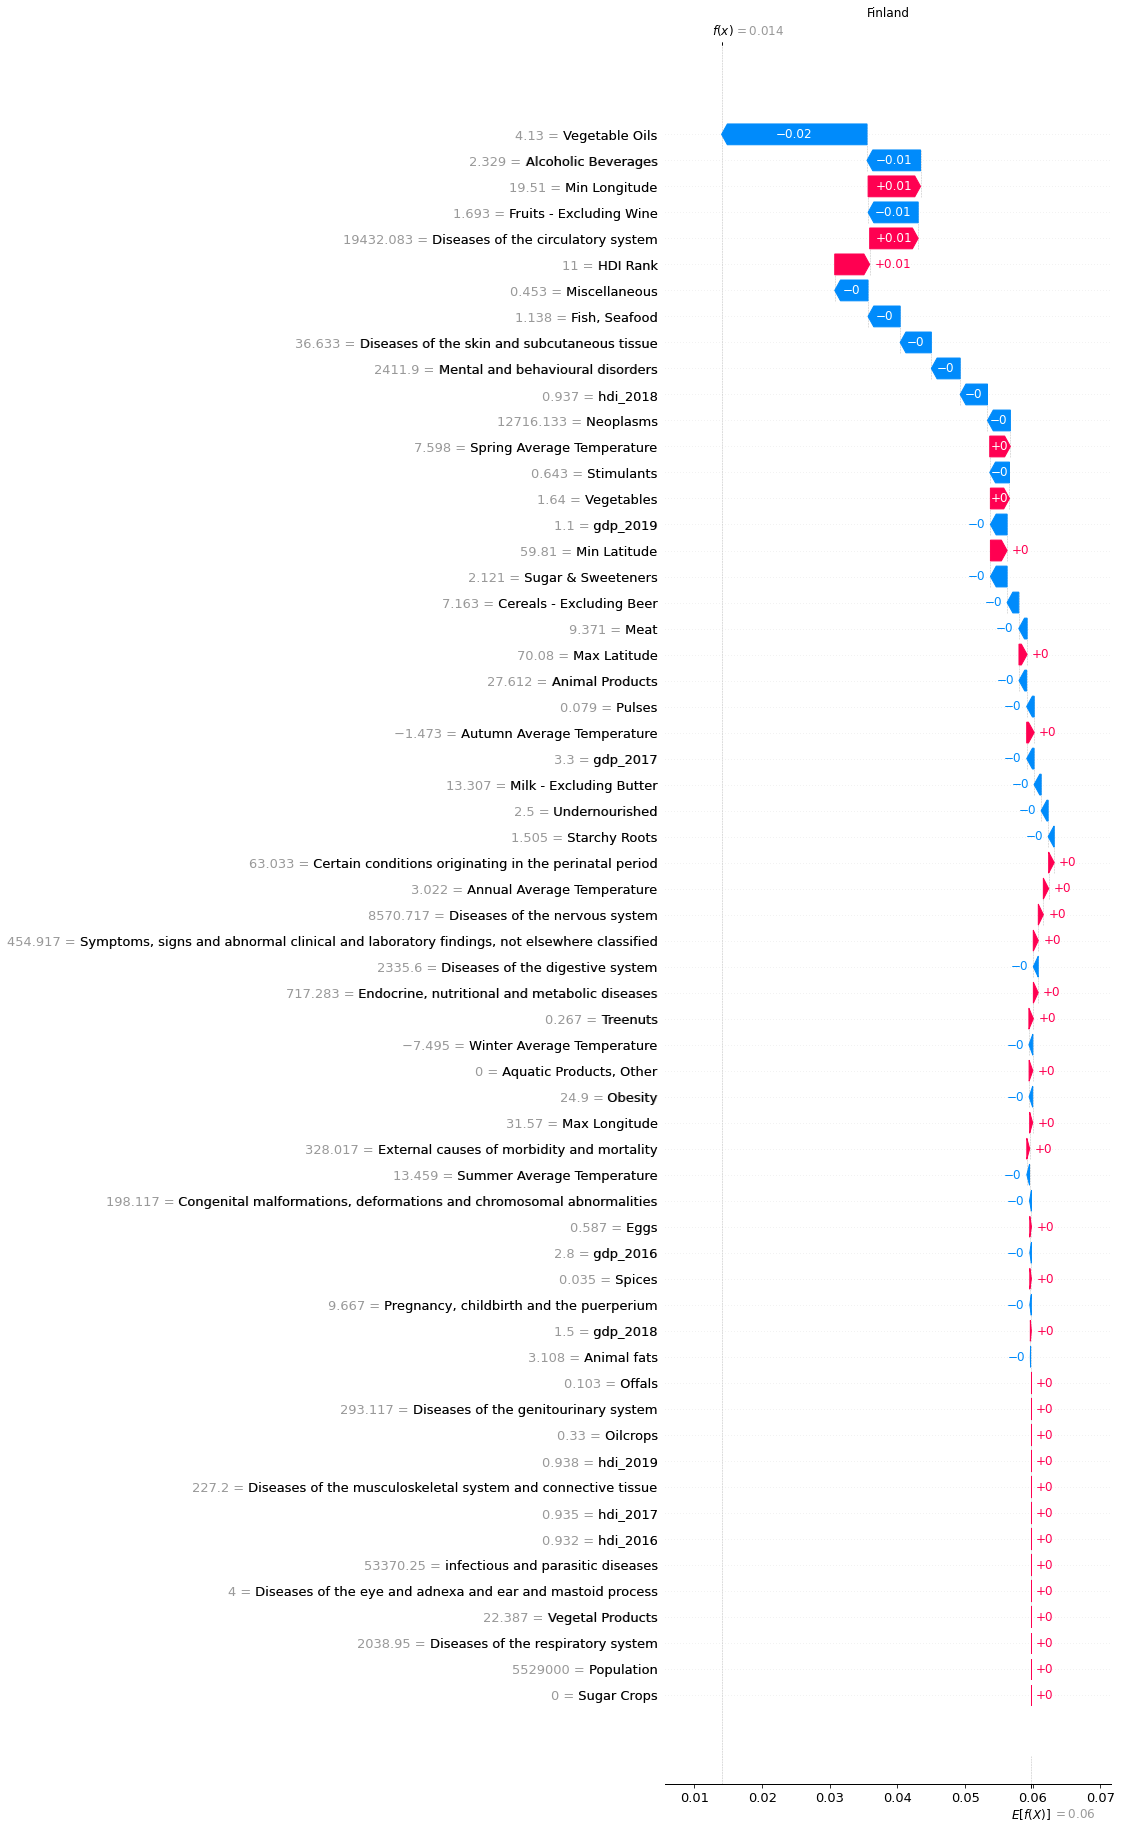

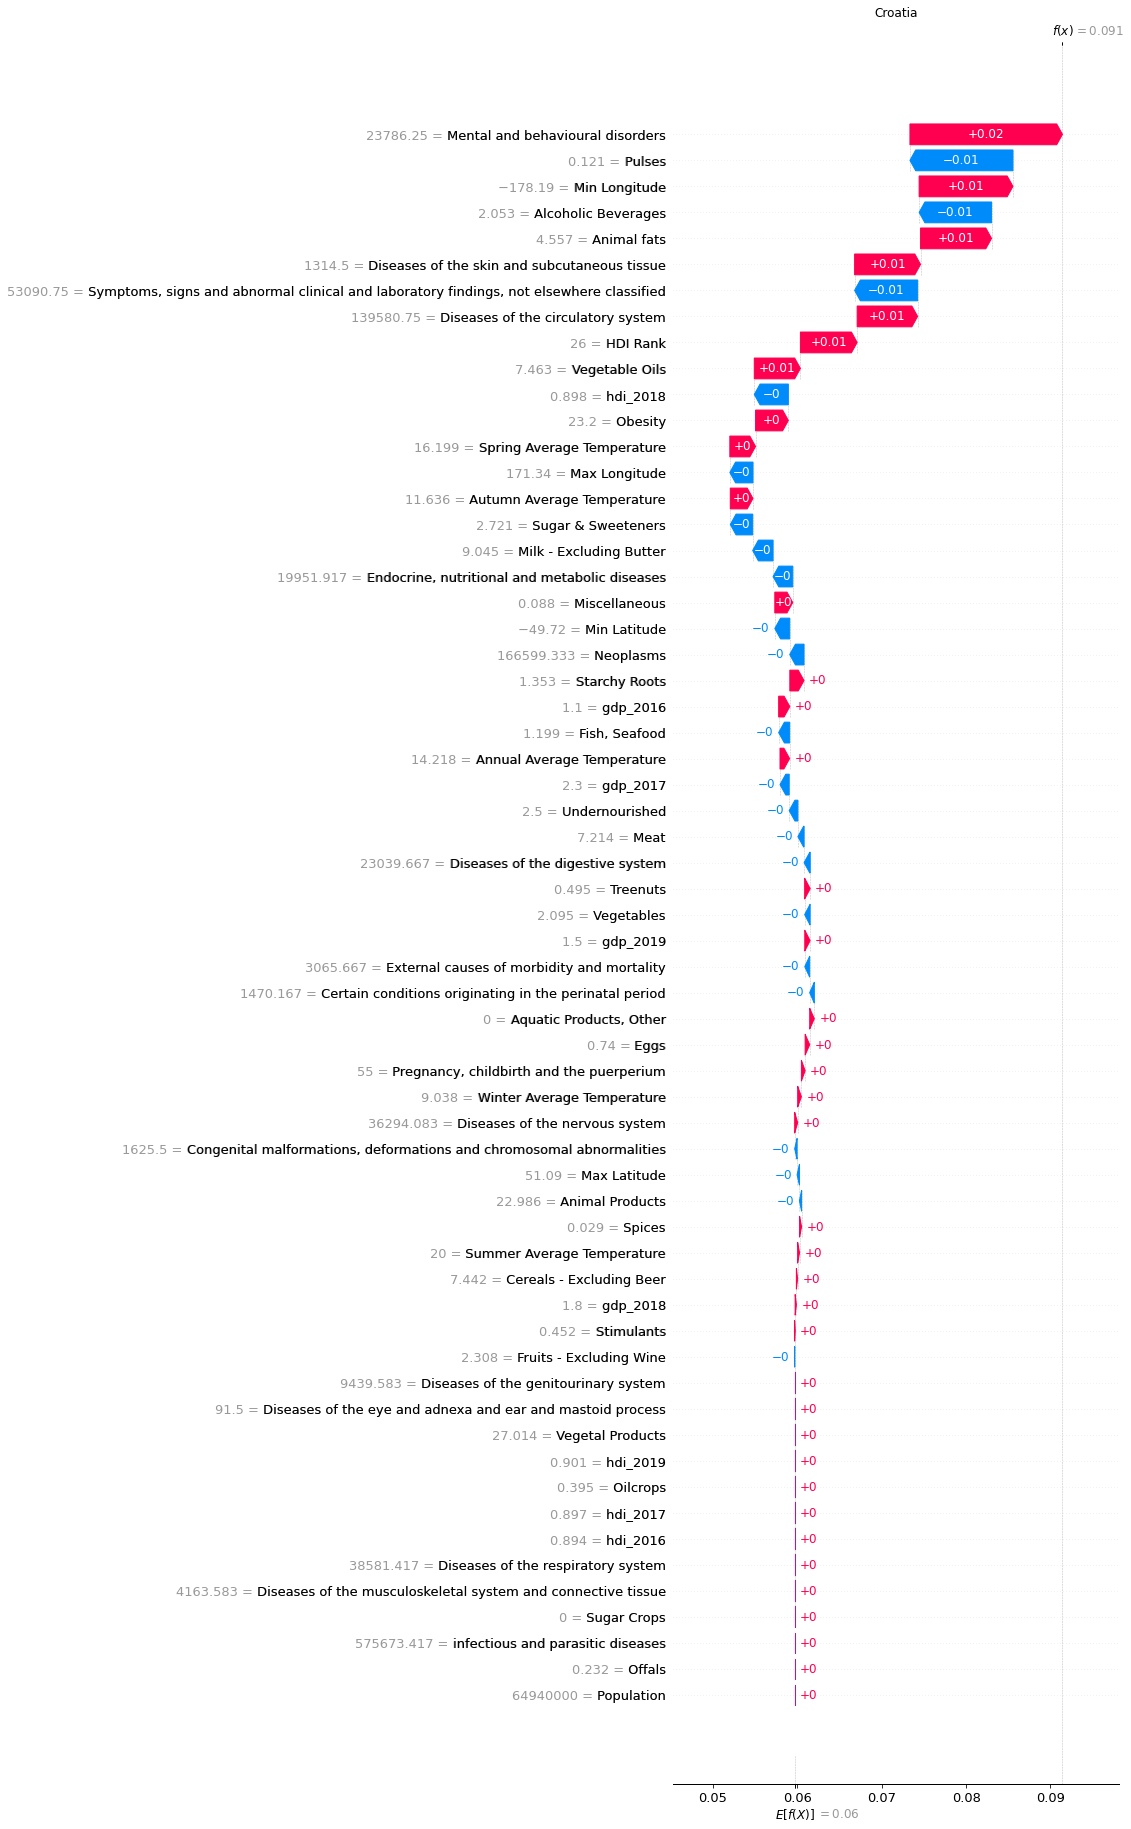

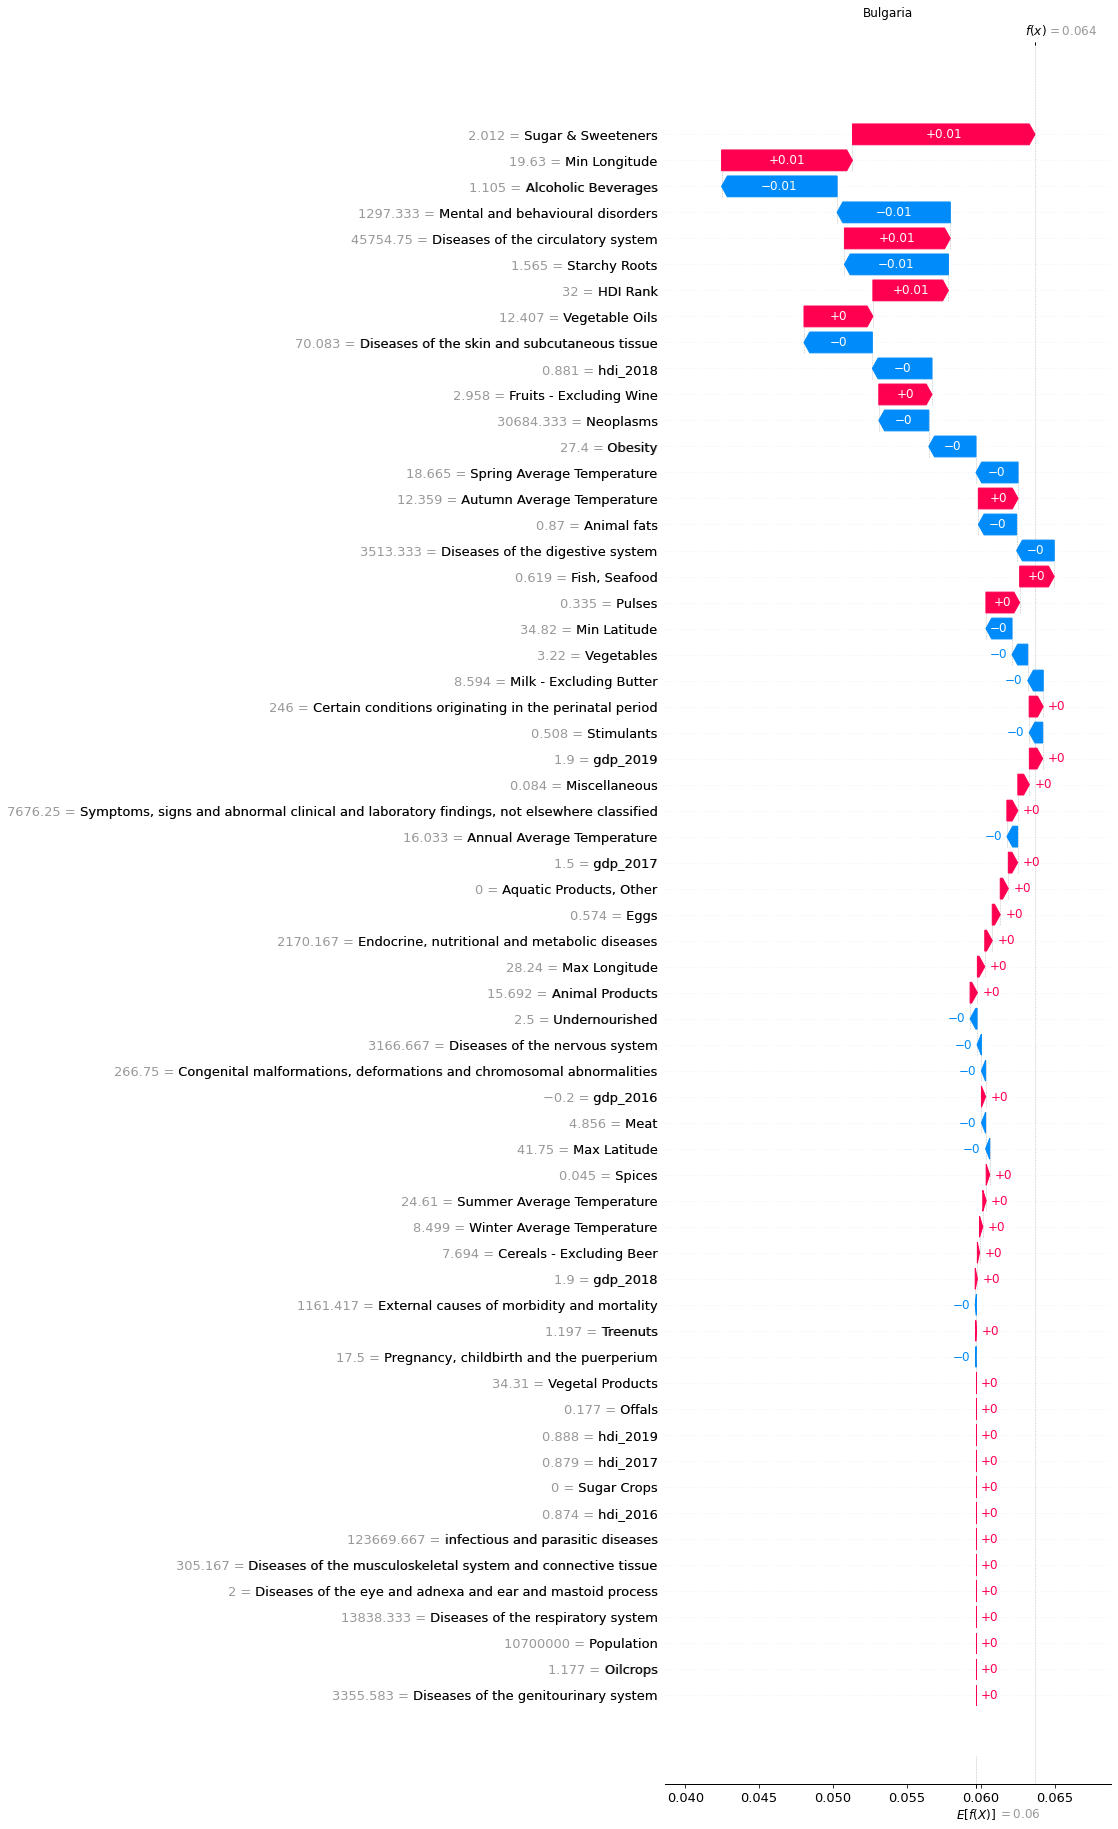

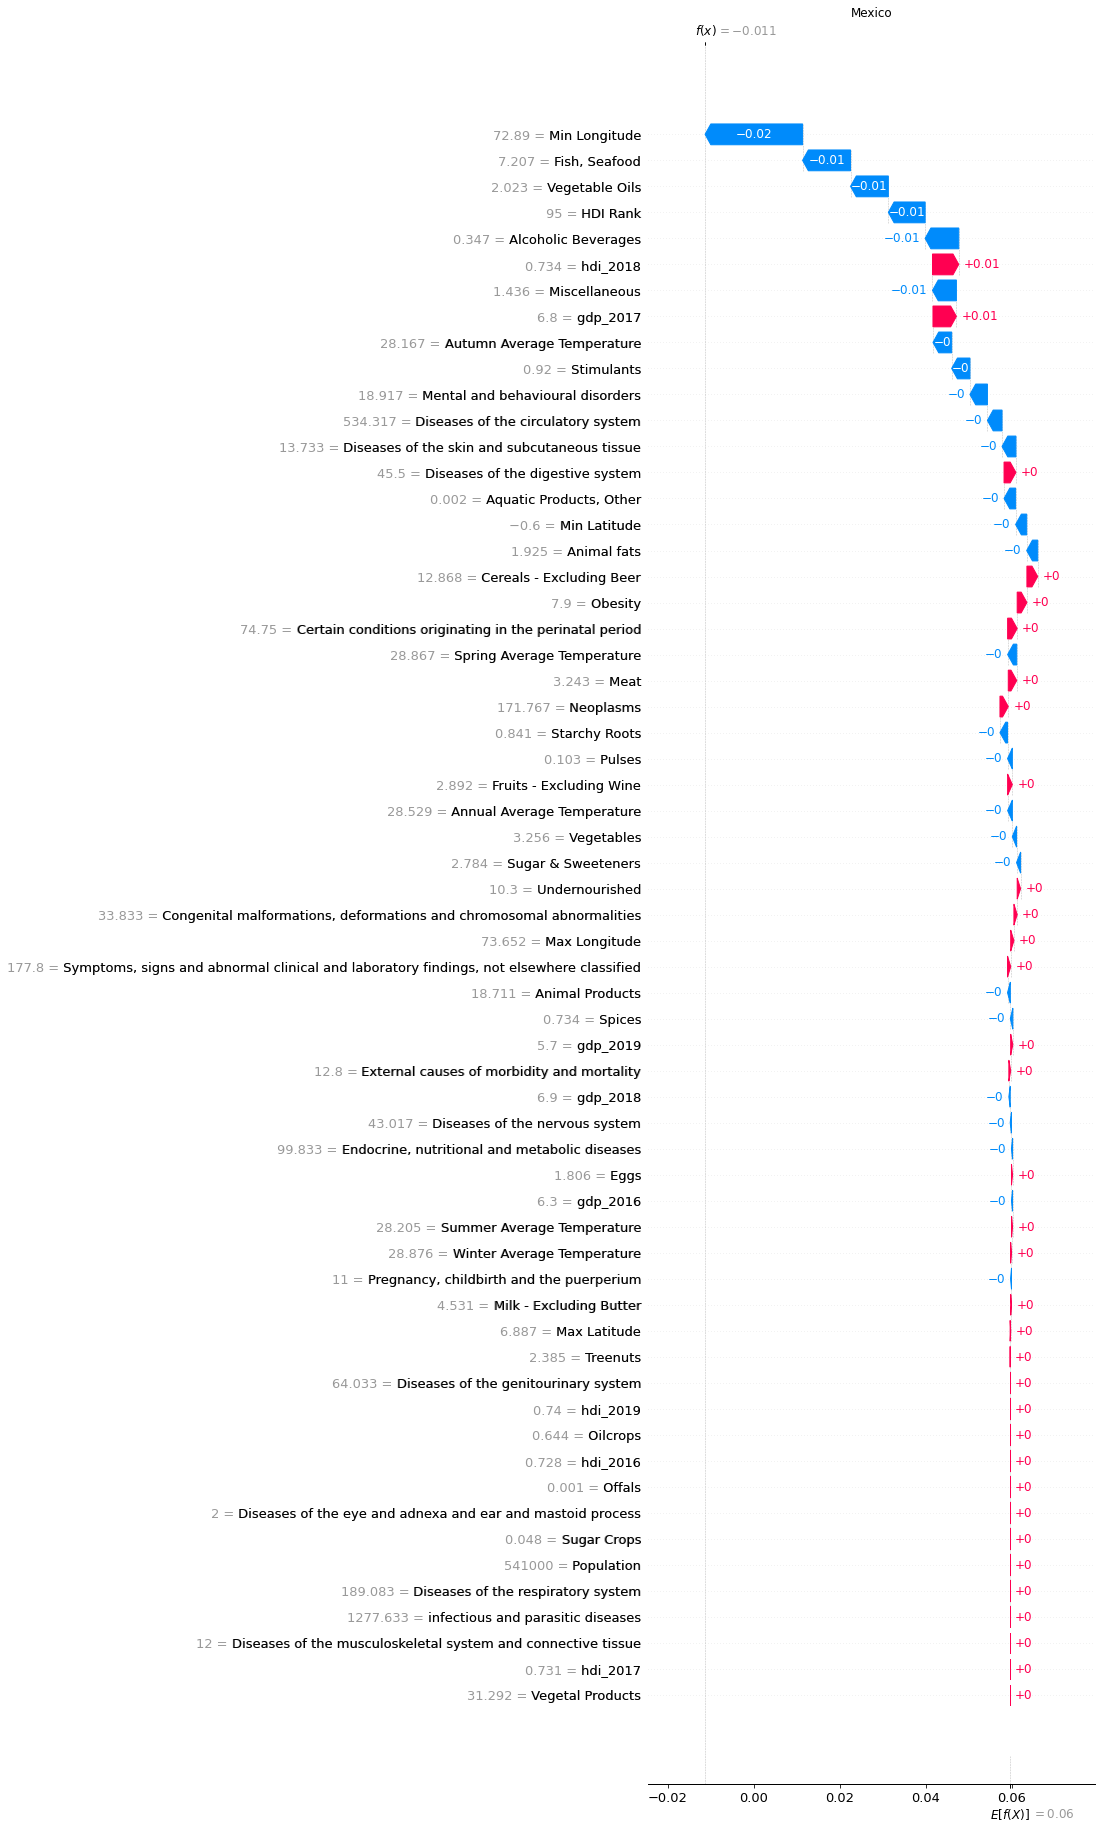

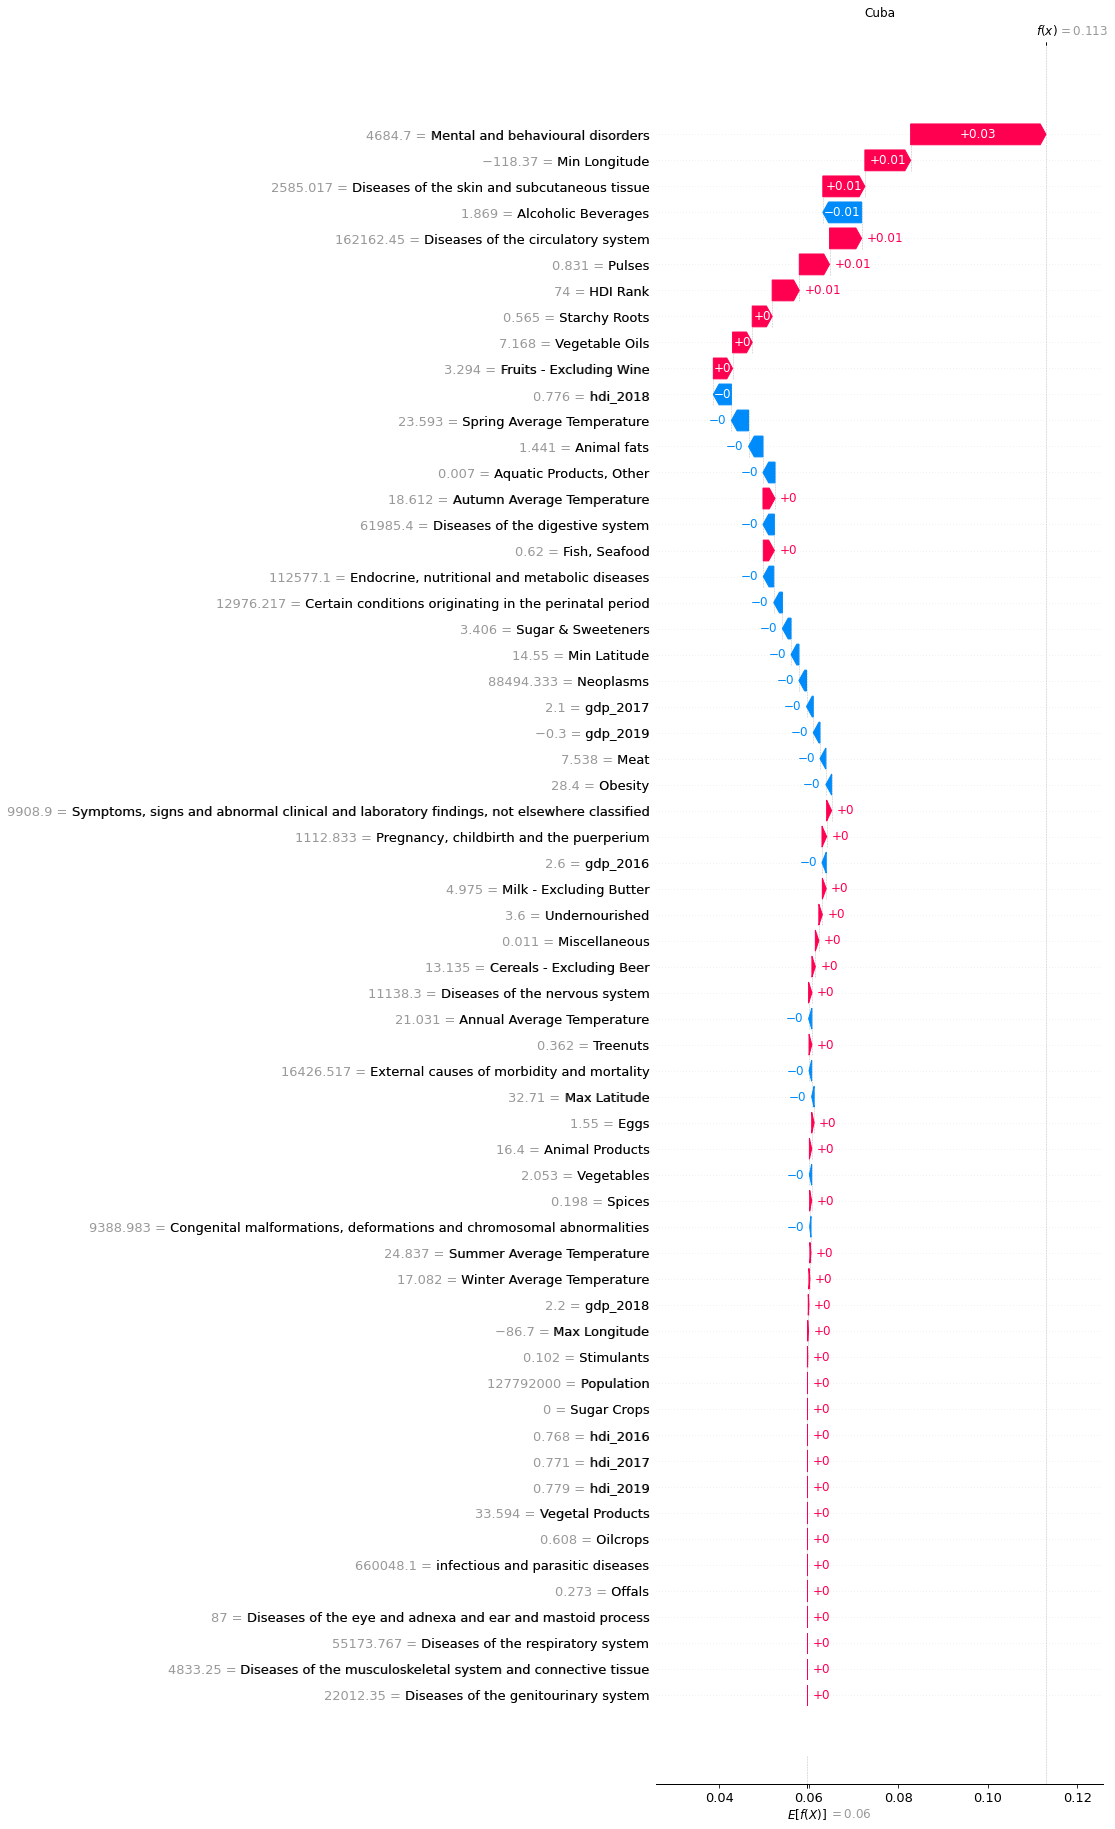

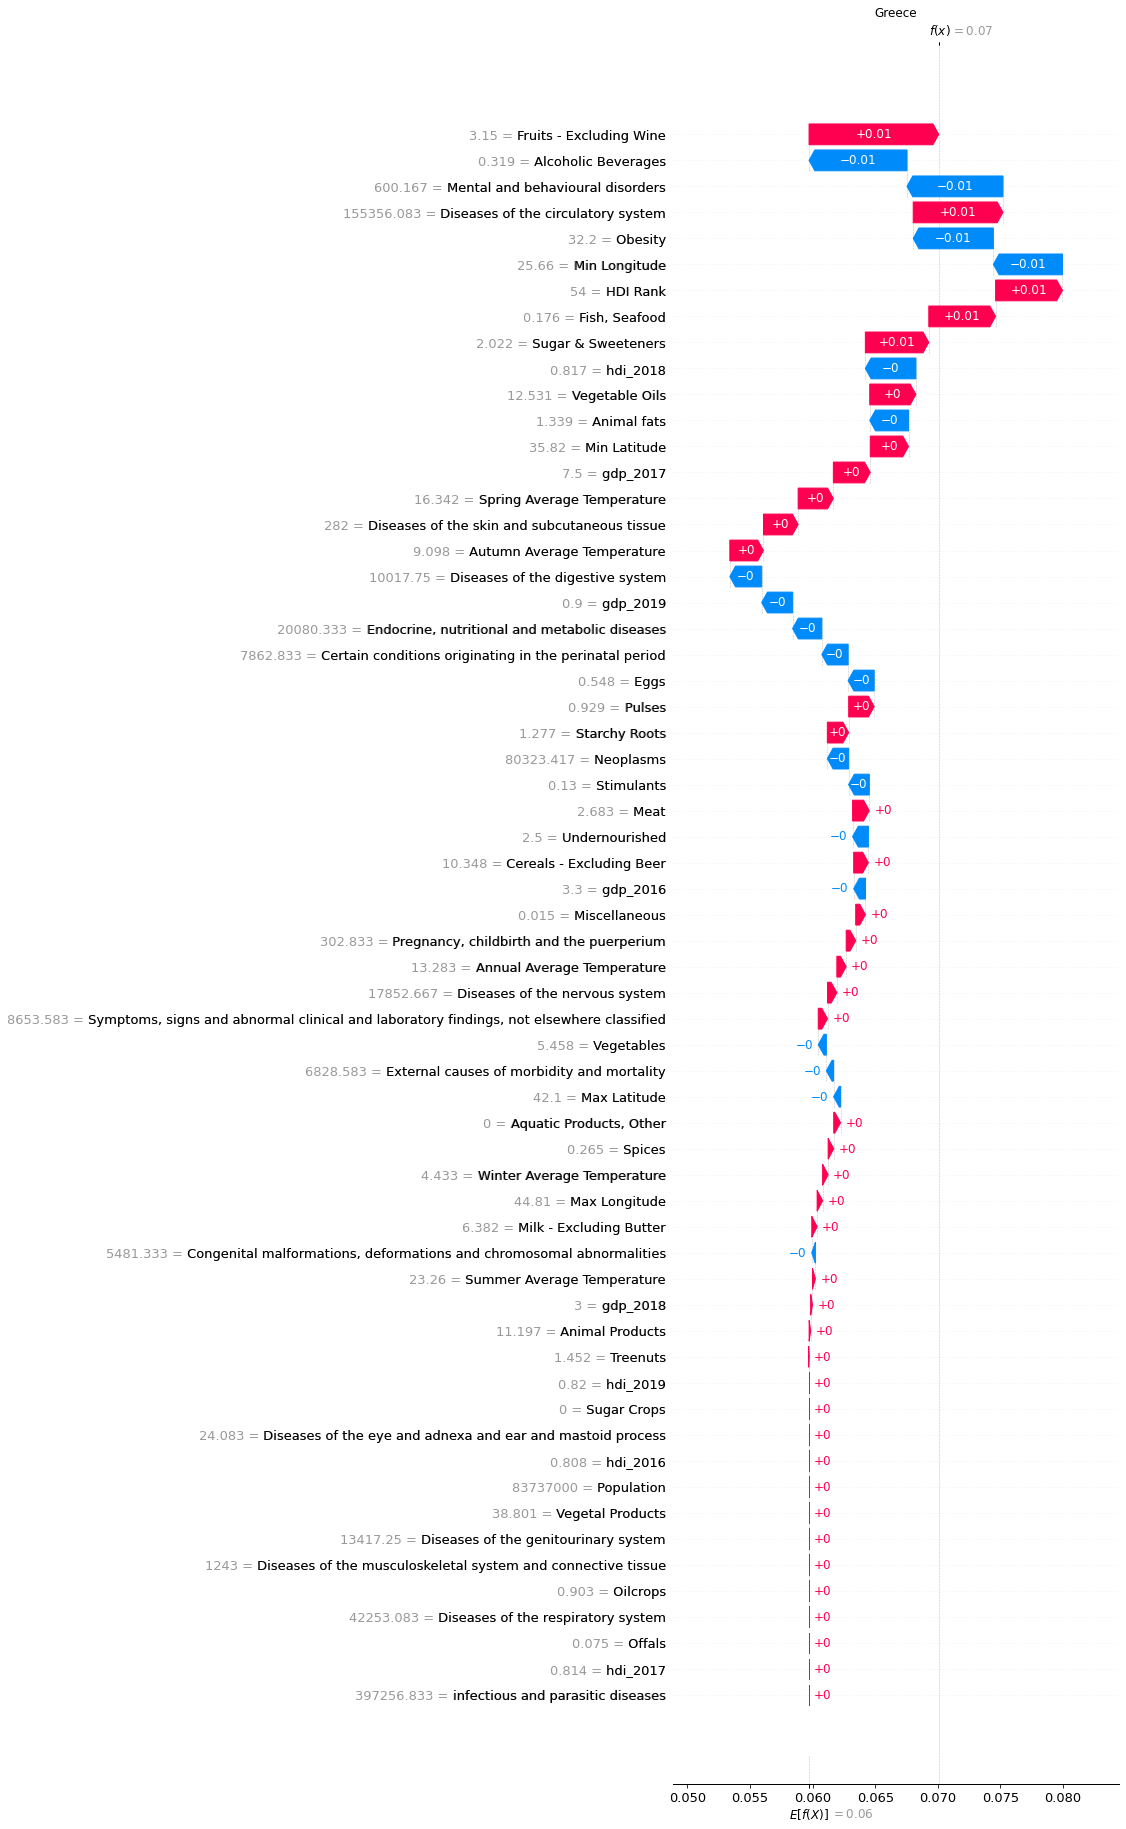

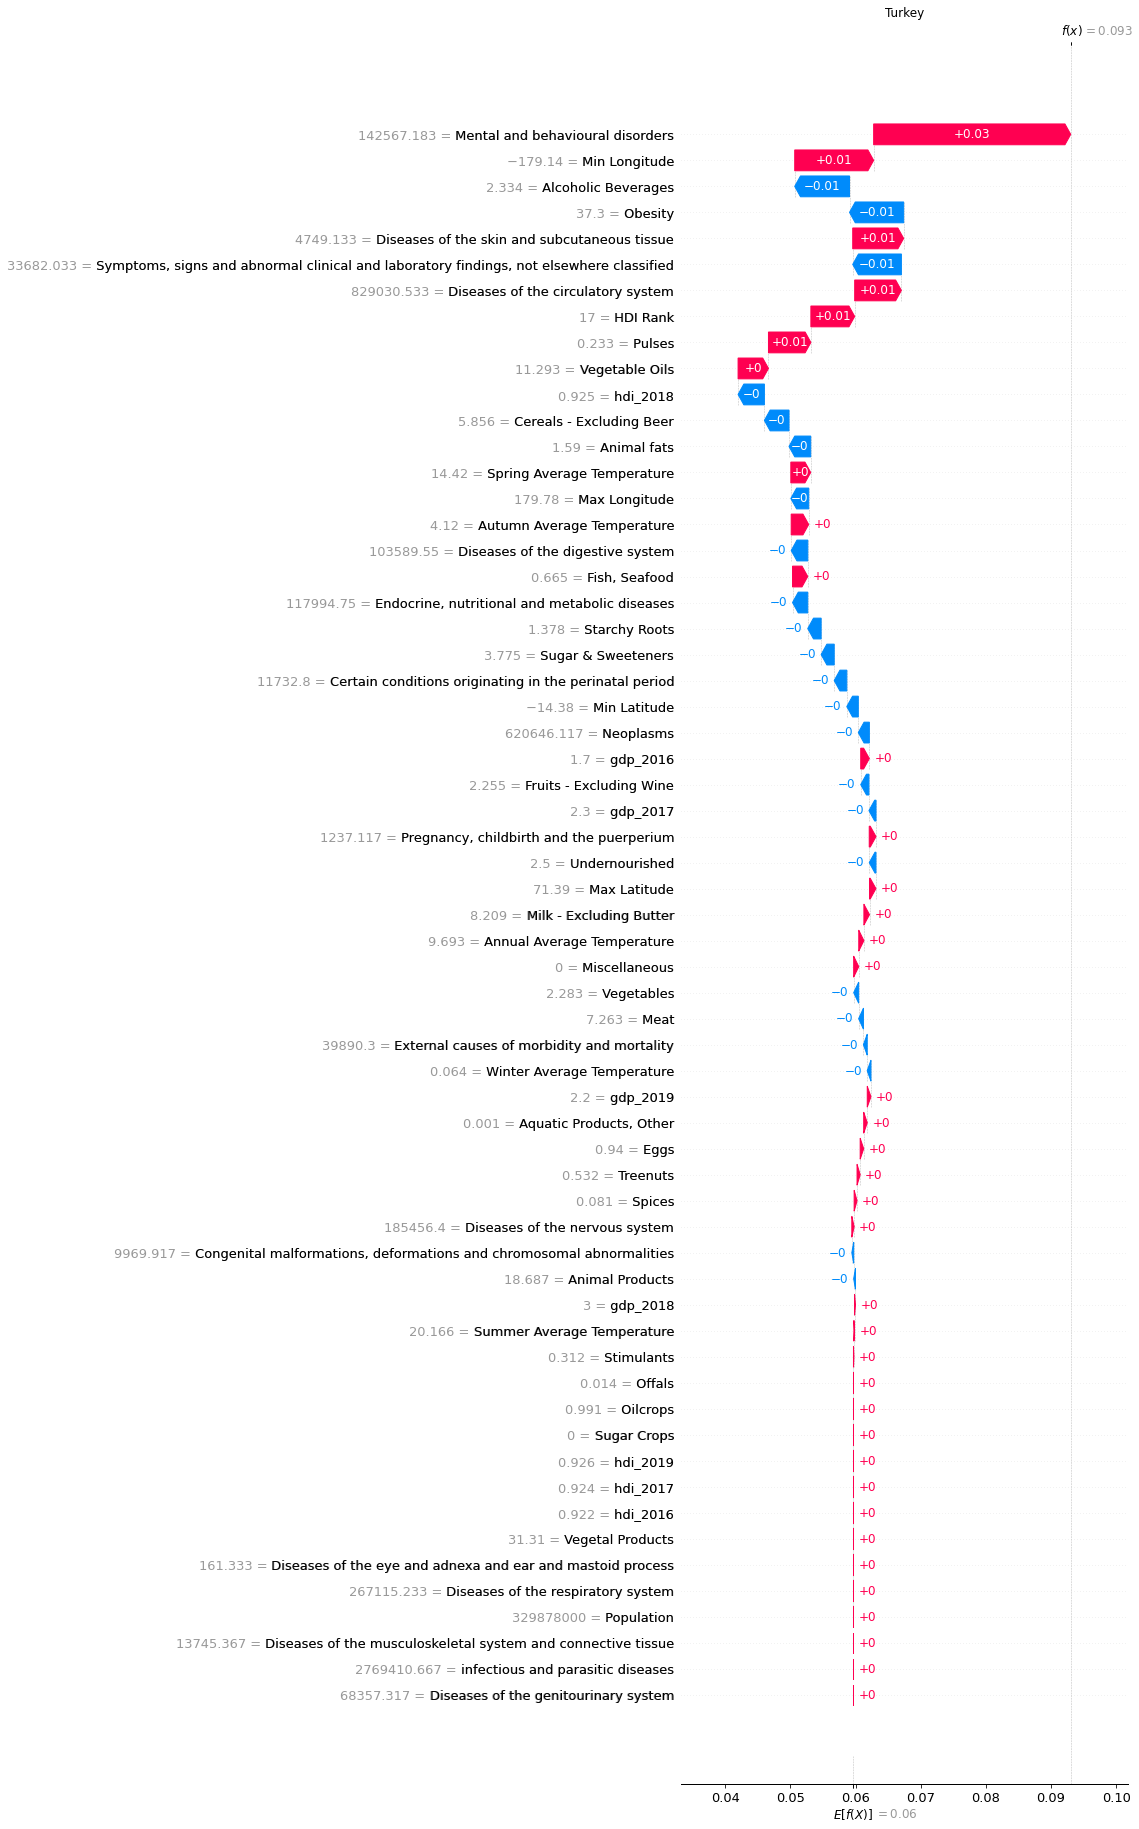

In [53]:
expl = shap.Explainer(xgb_all, X_all[selected_features_all])
shap_values = expl(X_all[selected_features_all])
shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.heatmap(shap_values)

countries = ['France', 'United States of America', 'Finland', 'Croatia', 'Bulgaria', 'Mexico', 'Cuba', 'Greece', 'Turkey', 'Maldives']
unscaled_train = unscaled_data.merge(targets, on='Country', how='inner')
indices = unscaled_train[unscaled_train['Country'].isin(countries)].index.values
unscaled_t = unscaled_train.drop(indices)

X_unscaled = unscaled_t[unscaled_t.columns.drop(label_values)]
X_unscaled = X_unscaled[X_unscaled.columns.drop('Country')]
X_fin = unscaled_train[unscaled_train.columns.drop(label_values)]
X_fin = X_fin[X_fin.columns.drop('Country')]
xgb_all.fit(X_unscaled, unscaled_t['Deaths'])
expl = shap.Explainer(xgb_all, X_fin)
shap_values = expl(X_fin)

for val, country in zip(indices, countries):
    plt.title(country)
    shap.plots.waterfall(shap_values[val], max_display=100)